In [5]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Load data
ego_alter_df = pd.read_csv('NetWorkSurvey.csv')  # Table 1
ego_df = pd.read_csv('BasicSurvey.csv')         # Table 2

# Create a graph
G = nx.Graph()

# Add all unique IDs from both tables to ensure no duplicates
all_ids = set(ego_df['egoid'])
all_alter_ids = set(ego_alter_df['alterid'])


health_mapping =  {
    'Poor':1,
    'Fair':2,
    'Good':3,
    'Excellent':4
}

health_dictionary = {}

# Add nodes with health attributes, ensuring values are numeric
for node_id in all_ids:
    ego_health = ego_df.loc[ego_df['egoid'] == node_id, 'Health_1']
    # Prefer health from ego table if available, otherwise use alter table
    health = ego_health.values[0] if not ego_health.empty else None

    # Convert health to numeric (default to None if conversion fails)
    try:
        health = health_mapping.get(health, None)
    except (ValueError, TypeError):
        health = None

    # Add node with numeric health attribute
    health_dictionary[node_id] = health
    G.add_node(node_id)

for node_id in all_alter_ids:
    alter_health = ego_alter_df.loc[ego_alter_df['alterid'] == node_id, 'althlth']
    health = alter_health.values[0] if not alter_health.empty else None
    try:
        health = health_mapping.get(health, None)
    except (ValueError, TypeError):
        health = None
    health_dictionary[node_id] = health
    G.add_node(node_id)



# Add edges with relationship attributes, ensuring numeric values for closeness
for _, row in ego_alter_df.iterrows():
    # Convert closeness to numeric using mapping
    closeness_mapping = {
        'Distant': 1,
        'LessThanClose': 2,
        'MerelyClose': 3,
        'EspeciallyClose': 4
    }
    closeness_numeric = closeness_mapping.get(row['close'], 1)  # Default to 1 if not found

    # Add edges only for true friends
    if row['friend']:
        G.add_edge(
            row['egoid'], row['alterid'],
            closeness_numeric=closeness_numeric,
            friend=row['friend']
        )


C:\Users\theroot\AppData\Local\Temp\ipykernel_19416\1471098075.py:6: DtypeWarning: Columns (14,15,29,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  ego_alter_df = pd.read_csv('NetWorkSurvey.csv')  # Table 1
C:\Users\theroot\AppData\Local\Temp\ipykernel_19416\1471098075.py:7: DtypeWarning: Columns (314,391,392,789,791,792,1124,1125,1227,1228,1231,1232,1477,1478,1554,1555,1556,1557,1558,1559,1561,1568,1571,1678,1687,1745,1746,1818,1836,1837,1843,1844,1849,1851,1852,1853,2072,2116,2117,2264,2266,2280,2281,2282,2283,2289,2290,2483,2484,2501,2502,2508,2509,2699,2711,2712,2830) have mixed types. Specify dtype option on import or set low_memory=False.
  ego_df = pd.read_csv('BasicSurvey.csv')         # Table 2


In [8]:
import math

ego_health_analysis = []

# Loop over all nodes to compute weighted average health
for ego in G.nodes:
    # Get neighbors (friends) of the ego
    if len(str(ego)) > 5:
        continue
    friends = [
        n for n in G.neighbors(ego) 
        if n in health_dictionary 
    ]
    
    if friends:
        weighted_sum = 0
        total_weight = 0

        for friend in friends:
            # Ensure both node and edge attributes exist
            if friend in health_dictionary and 'closeness_numeric' in G.edges[ego, friend]:
                health = health_dictionary[friend]
                closeness = G.edges[ego, friend]['closeness_numeric']

                # Validate and convert to numeric
                if health is not None and closeness is not None:
                    weighted_sum += health * closeness
                    total_weight += closeness

        # Avoid division by zero
        weighted_avg_health = weighted_sum / total_weight if total_weight > 0 else None
    else:
        weighted_avg_health = None

    # Ensure 'health' exists for the ego node before accessing it
    ego_health = health_dictionary.get(ego, None)

    ego_health_analysis.append({
        'node_id': ego,
        'health': ego_health,
        'weighted_avg_friends_health': weighted_avg_health
    })

# Convert results to a DataFrame for analysis
health_df = pd.DataFrame(ego_health_analysis).dropna()
print(health_df)


     node_id  health  weighted_avg_friends_health
0      38914     4.0                     4.000000
3      81930     4.0                     3.000000
12     79897     4.0                     4.000000
34     43125     3.0                     4.000000
43     28824     2.0                     3.000000
47     98462     4.0                     3.545455
71     35031     4.0                     3.789474
75     26857     4.0                     2.000000
102    51495     4.0                     3.727273
111    22842     3.0                     3.000000
122    67918     2.0                     4.000000
125    49497     2.0                     3.363636
166    94662     4.0                     3.750000
169    98760     4.0                     4.000000
179    33239     3.0                     3.769231
184    10732     4.0                     4.000000
208    37404     3.0                     3.000000
228    29257     4.0                     3.025641
287    56058     4.0                     3.941176


Pearson Correlation: -0.04, p-value: 8.05e-01


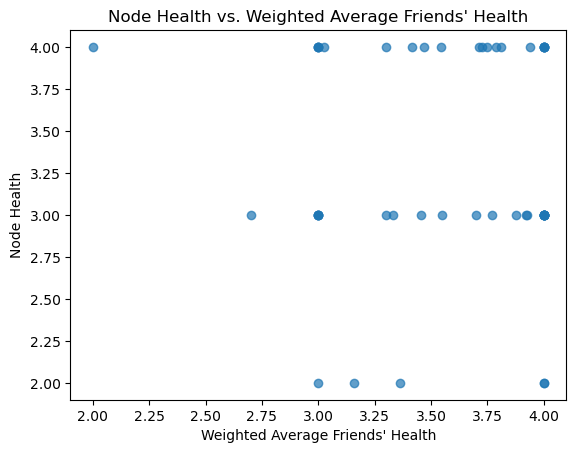

In [9]:
from scipy.stats import pearsonr

# Drop rows with missing data
health_df_cleaned = health_df.dropna()

# Correlation analysis
if not health_df_cleaned.empty:
    correlation, p_value = pearsonr(
        health_df_cleaned['health'],
        health_df_cleaned['weighted_avg_friends_health']
    )
    print(f"Pearson Correlation: {correlation:.2f}, p-value: {p_value:.2e}")

    # Plot the relationship
    plt.scatter(
        health_df_cleaned['weighted_avg_friends_health'],
        health_df_cleaned['health'],
        alpha=0.7
    )
    plt.title("Node Health vs. Weighted Average Friends' Health")
    plt.xlabel("Weighted Average Friends' Health")
    plt.ylabel("Node Health")
    plt.show()
else:
    print("No valid data for correlation analysis.")


In [16]:
import math

ego_health_analysis_unweighted = []

# Loop over all nodes to compute unweighted average health
for ego in G.nodes:
    # Get neighbors (friends) of the ego
    friends = [
        n for n in G.neighbors(ego)
        if n in health_dictionary
    ]

    if friends:
        # Compute unweighted sum of friends' health
        total_health = 0 
        num_friends = 0
        for friend in friends:
            friend_health = health_dictionary.get(friend, -1)
            if friend_health is not None and friend_health != -1:
                total_health += friend_health
                num_friends +=1 
        if num_friends >0:
            unweighted_avg_health = total_health / num_friends
        else:
            unweighted_avg_health = None
    else:
        unweighted_avg_health = None

    # Ensure 'health' exists for the ego node before accessing it
    ego_health = health_dictionary.get(ego, None)

    # Append the result
    ego_health_analysis_unweighted.append({
        'node_id': ego,
        'health': ego_health,
        'unweighted_avg_friends_health': unweighted_avg_health
    })

# Convert results to a DataFrame for analysis
health_df_unweighted = pd.DataFrame(ego_health_analysis_unweighted).dropna()
print(health_df_unweighted)


       node_id  health  unweighted_avg_friends_health
0        38914     4.0                            4.0
3        81930     4.0                            3.0
12       79897     4.0                            4.0
34       43125     3.0                            4.0
43       28824     2.0                            3.0
...        ...     ...                            ...
15609   327243     4.0                            3.0
15624   622190     4.0                            3.0
15667   229061     3.0                            4.0
15685   360162     4.0                            3.0
15811   950227     4.0                            4.0

[320 rows x 3 columns]


Pearson Correlation (Unweighted): -0.06, p-value: 2.68e-01


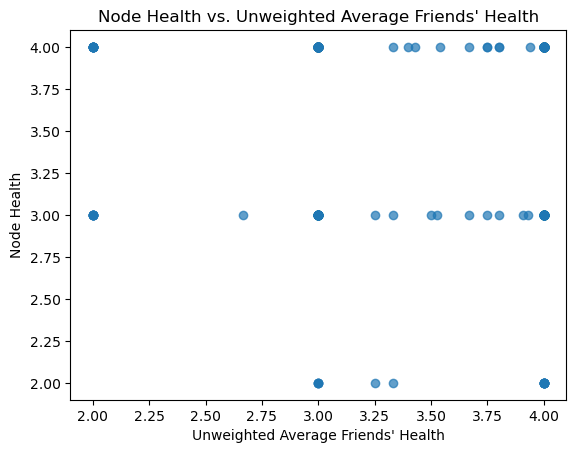

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Drop rows with missing data
health_df_unweighted_cleaned = health_df_unweighted.dropna()

# Correlation analysis
if not health_df_unweighted_cleaned.empty:
    correlation, p_value = pearsonr(
        health_df_unweighted_cleaned['health'],
        health_df_unweighted_cleaned['unweighted_avg_friends_health']
    )
    print(f"Pearson Correlation (Unweighted): {correlation:.2f}, p-value: {p_value:.2e}")

    # Scatterplot
    plt.scatter(
        health_df_unweighted_cleaned['unweighted_avg_friends_health'],
        health_df_unweighted_cleaned['health'],
        alpha=0.7
    )
    plt.title("Node Health vs. Unweighted Average Friends' Health")
    plt.xlabel("Unweighted Average Friends' Health")
    plt.ylabel("Node Health")
    plt.show()
else:
    print("No valid data for correlation analysis.")
